# Experiment Figures and Tables

## Imports

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = Path(os.getcwd()).parents[0]
sys.path.append(str(path_root))
%reload_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from copy import deepcopy
import mlflow

In [3]:
import jax
import jax.numpy as jnp

In [4]:
from ffbq.eval import get_experiments, best_operator_models, seed_summary, best_operator_plurality
import numpy as np

## Gaussian Mixture

In [ ]:
# plt.rcParams.update({

# })
sns.set_theme()
sns.set_context("paper", rc={
    # 'font.size': 10,
    "axes.labelsize": 13,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})
# plt.style.use('tex')

In [31]:
gmm = "gmm_kmu_sr"
gmm_sr, gmm_cols = get_experiments(gmm, all_cols=True)
gmm_sr = gmm_sr[["gptype", "operator", "Nconv", "sol_mu", "sol_var", "bqerr", "bqvar_err", "bqz_err"]]
gmm_sr[["Nconv", "sol_mu", "sol_var", "bqerr", "bqvar_err", "bqz_err"]] = gmm_sr[["Nconv", "sol_mu", "sol_var", "bqerr", "bqvar_err", "bqz_err"]].astype(float)

In [32]:
gmm_sum = gmm_sr.groupby(["operator", "Nconv"])[["sol_mu", "sol_var", "bqerr", "bqvar_err", "bqz_err"]].agg(("mean", "std")).reset_index()
gmm_sum.columns = ["_".join(col) if '' not in col else col[0] for col in gmm_sum.columns]

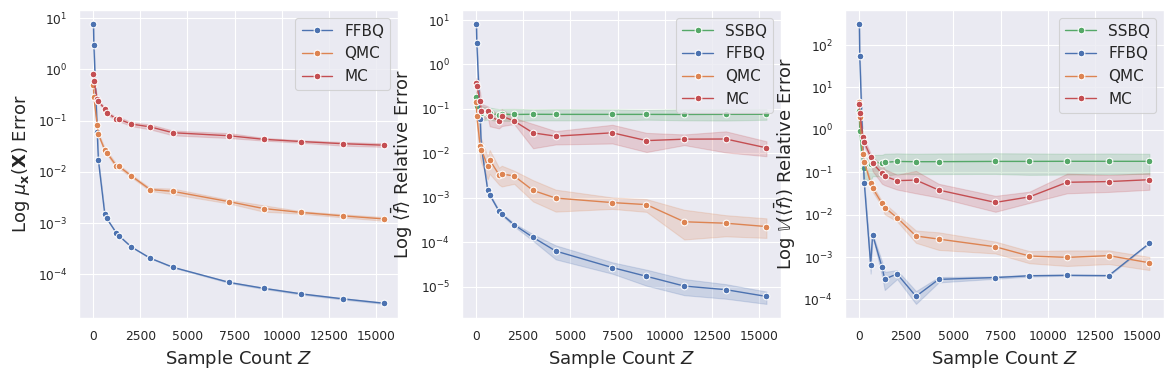

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

# KERNEL MEAN
gmm_sr_plot = gmm_sr.copy()
gmm_sr_plot["rel_err"] = gmm_sr_plot["bqerr"] / gmm_sr_plot["sol_mu"]

sns.lineplot(
    gmm_sr_plot[gmm_sr_plot["operator"] != "ssbq"], x="Nconv", y="bqz_err", hue="operator",
    linewidth=1, marker="o", ax=ax[0], palette=["#4c72b0", "#dd8452", "#c44e52"]
)
ax[0].set(yscale="log", xlabel="Sample Count $Z$", ylabel="Log $\mu_{\mathbf{x}}(\mathbf{X})$ Error")
handles0, labels0 = ax[0].get_legend_handles_labels()
ax[0].legend(handles=handles0, labels=["FFBQ", "QMC", "MC"], fontsize=11)

# # MEAN
sns.lineplot(
    gmm_sr_plot, x="Nconv", y="rel_err", palette=["#55a868", "#4c72b0", "#dd8452", "#c44e52"],
    linewidth=1, marker="o", hue="operator", ax=ax[1]
)
ax[1].set(yscale="log", xlabel="Sample Count $Z$", ylabel="Log $\langle \\bar{f} \\rangle$ Relative Error")
handles1, labels1 = ax[1].get_legend_handles_labels()
ax[1].legend(handles=handles1, labels=["SSBQ", "FFBQ", "QMC", "MC"], fontsize=11)

# # VARIANCE
gmm_sr_plot["rel_err_var"] = gmm_sr_plot["bqvar_err"] / gmm_sr_plot["sol_var"]
sns.lineplot(
    gmm_sr_plot, x="Nconv", y="rel_err_var",palette=["#55a868", "#4c72b0", "#dd8452", "#c44e52"],
    linewidth=1, marker="o", hue="operator", ax=ax[2]
)
ax[2].set(yscale="log", xlabel="Sample Count $Z$", ylabel="Log $\mathbb{V}(\langle \\bar{f} \\rangle)$ Relative Error")
handles2, labels2 = ax[2].get_legend_handles_labels()
ax[2].legend(handles=handles2, labels=["SSBQ", "FFBQ", "QMC", "MC"], fontsize=11)

# plt.show()
# fig.savefig("gmm.pdf", format="pdf", bbox_inches="tight")

In [41]:
gmm_R_name = "gmm_lr_R"
gmm_R, gmm_exp_cols = get_experiments(gmm_R_name, all_cols=True)
gmm_R = gmm_R[["R", "d", "sol_mu", "sol_var", "bqerr", "bqvar_err"]].astype(float)

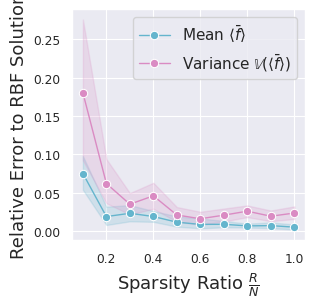

In [42]:
# # LOW RANK APPROXIMATION
fig, ax = plt.subplots(figsize=(3, 3))
gmm_R_plot = gmm_R.copy()
gmm_R_plot["rel_err"] = gmm_R_plot["bqerr"] / gmm_R_plot["sol_mu"]
gmm_R_plot["rel_err_var"] = gmm_R_plot["bqvar_err"] / gmm_R_plot["sol_var"]
gmm_R_plot["sparsity"] = gmm_R_plot["R"] / 1000

sns.set_theme()
sns.lineplot(
    gmm_R_plot[gmm_R_plot["d"] == 2], x="sparsity", y="rel_err",
    linewidth=1, marker="o", label="Mean $\langle \\bar{f} \\rangle$", c='#64b5cd', ax=ax
)
sns.lineplot(
    gmm_R_plot[gmm_R_plot["d"] == 2], x="sparsity", y="rel_err_var",
    linewidth=1, marker="o", label="Variance $\mathbb{V}(\langle \\bar{f} \\rangle)$", c='#da8bc3', ax=ax
)
ax.set(xlabel="Sparsity Ratio $\\frac{R}{N}$", ylabel="Relative Error to RBF Solution")
fig.savefig("ssbq.pdf", format="pdf", bbox_inches="tight")

## Continuous

### Summarize Runs

In [6]:
continuous = "continuous_dev_d"
cont_exps, cont_exp_cols = get_experiments(continuous)
cont_sum = seed_summary(cont_exps, cont_exp_cols, "d")

In [ ]:
cont_each_d = best_operator_models(cont_sum, metric="nll_mean", setting="d")
cont_each_d = cont_each_d[~cont_each_d["operator"].isin(["lrfft", "mc"])]
cont_over_d = best_operator_plurality(cont_sum, cont_each_d)

### Variance

In [14]:
cont_var, cont_var_cols = get_experiments("continuous_var")
cont_var_sum = seed_summary(cont_var, cont_var_cols, "d")

In [15]:
cont_var_each_d = best_operator_models(cont_var_sum, metric="nll_mean", setting="d")
cont_var_each_d = cont_var_each_d[~cont_var_each_d["operator"].isin(["lrfft", "mc"])]
cont_var_over_d = best_operator_plurality(cont_var_sum, cont_var_each_d)
cont_var_over_d["z_score_mean"] = abs(cont_var_over_d["z_score_mean"])

In [40]:
cont_var_over_d

,gptype,ktype,operator,sol,d,bqres_mean,bqres_std,bqerr_mean,bqerr_std,bqrel_mean,...,nll_mean,nll_std,bqvar_mean,bqvar_std,z_score_mean,z_score_std,one_sd_mean,one_sd_std,two_sd_mean,two_sd_std
0,gp,fin,qmc,0.1470510688313898,2,0.147303,0.002876,0.002351,0.001484,0.015984,...,-2766.611011,54.139262,0.000036,0.000016,0.002942,0.497962,1.0,0.000000,1.0,0.0
1,gp,fin,ffbq,0.1470510688313898,2,0.148526,0.002874,0.002573,0.001823,0.017497,...,-2766.611011,54.139262,0.000036,0.000011,0.229675,0.474632,1.0,0.000000,1.0,0.0
2,gp,rbf,gaussian,0.1470510688313898,2,0.145725,0.004670,0.004208,0.002022,0.028613,...,-2428.531567,258.193675,0.001027,0.000005,0.041587,0.145808,1.0,0.000000,1.0,0.0
3,lr,rff,ssbq,0.1470510688313898,2,0.146898,0.005501,0.004864,0.001999,0.033076,...,-468.251636,971.304230,0.001037,0.000005,0.004877,0.170918,1.0,0.000000,1.0,0.0
4,gp,rbf,gaussian,0.05639002384646558,3,0.055508,0.002843,0.002284,0.001775,0.040505,...,-2507.822119,254.014104,0.001033,0.000017,0.027684,0.088590,1.0,0.000000,1.0,0.0
5,lr,rff,ssbq,0.05639002384646558,3,0.054581,0.002088,0.002324,0.001413,0.041207,...,-2477.151367,334.518554,0.001071,0.000019,0.055659,0.064206,1.0,0.000000,1.0,0.0
6,gp,fin,qmc,0.05639002384646558,3,0.058067,0.004375,0.003896,0.002325,0.069083,...,-1171.078027,29.825443,0.000048,0.000003,0.243126,0.629466,0.8,0.421637,1.0,0.0
7,gp,fin,ffbq,0.05639002384646558,3,0.059723,0.004626,0.004290,0.003646,0.076076,...,-1171.078027,29.825443,0.000054,0.000004,0.455624,0.622093,0.7,0.483046,1.0,0.0
8,gp,fin,qmc,0.021624016844454134,4,0.020045,0.002617,0.002380,0.001823,0.110068,...,333.113318,10.137656,0.000208,0.000012,0.109907,0.181437,1.0,0.000000,1.0,0.0
9,gp,fin,ffbq,0.021624016844454134,4,0.019792,0.002797,0.002862,0.001566,0.132331,...,333.113318,10.137656,0.000291,0.000017,0.108467,0.166286,1.0,0.000000,1.0,0.0


#### Variance Plots

In [68]:
# plt.rcParams.update({

# })
sns.set_theme()
tex_fonts = {
    # 'font.size': 10,
    'text.usetex': True,
    "font.family": "serif",
    "axes.labelsize": 14,
    'text.latex.preamble': r'\usepackage{amsfonts}'
}
sns.set_context("paper", rc=tex_fonts)
# plt.style.use('tex')

plt.rcParams.update(tex_fonts)

In [69]:
best_operators = [("fin", "qmc"), ("rff", "ssbq"), ("fin", "ffbq"), ("rbf", "gaussian")]

plot_frames = []
for op in best_operators:
    plot_frames.append(cont_var[(cont_var["operator"] == op[1]) & (cont_var["ktype"] == op[0])])
var_plot_df = pd.concat(plot_frames).sort_values(["d", "operator"]).reset_index(drop=True)
var_plot_df["z_score"] = abs(var_plot_df["z_score"])

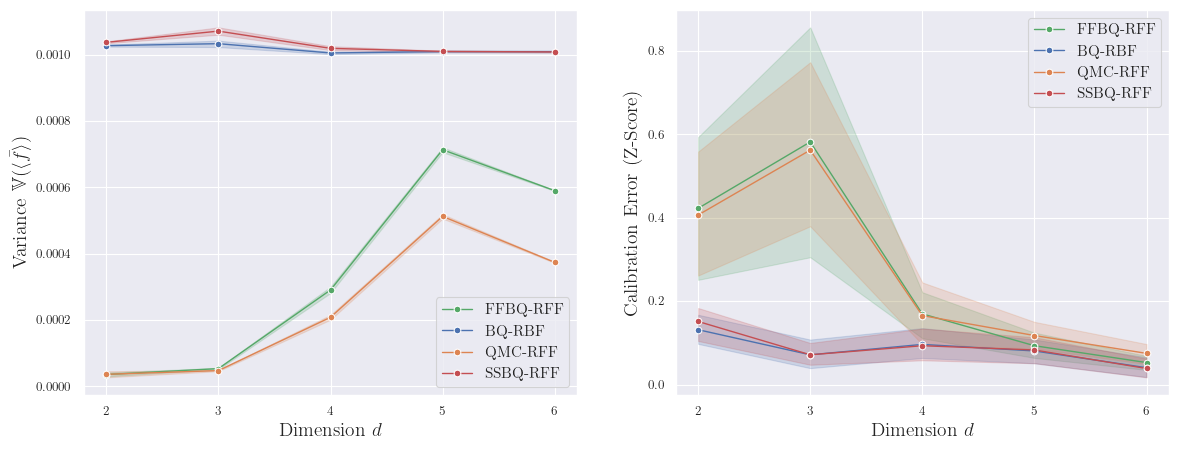

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# VARIANCE
sns.lineplot(
    var_plot_df, x="d", y="bqvar", hue="operator",
    linewidth=1, marker="o", ax=ax[0], palette=["#55a868", "#4c72b0", "#dd8452", "#c44e52"]
)
ax[0].set(xlabel="Dimension $d$", ylabel="Variance $\mathbb{V} (\langle \\bar{f} \\rangle)$")
handles1, labels1 = ax[0].get_legend_handles_labels()
ax[0].legend(handles=handles0, labels=["FFBQ-RFF", "BQ-RBF", "QMC-RFF", "SSBQ-RFF"], fontsize=11)


# ZSCORE
sns.lineplot(
    var_plot_df, x="d", y="z_score", hue="operator",
    linewidth=1, marker="o", ax=ax[1] , palette=["#55a868", "#4c72b0", "#dd8452", "#c44e52"]
)
ax[1].set(xlabel="Dimension $d$", ylabel="Calibration Error (Z-Score)")
handles0, labels0 = ax[1].get_legend_handles_labels()
ax[1].legend(handles=handles0, labels=["FFBQ-RFF", "BQ-RBF", "QMC-RFF", "SSBQ-RFF"], fontsize=11)

plt.show()
fig.savefig("var.pdf", format="pdf", bbox_inches="tight")

### Produce Tables

In [22]:
cont_tab = cont_over_d[["operator", "ktype", "d", "bqerr_mean", "bqerr_std"]]
cont_tab = cont_tab[cont_tab["d"].isin(['2', '4', '6'])]
cont_tab["model"] = cont_tab["operator"] + " " + cont_tab["ktype"]
cont_tab = cont_tab.drop(columns=["operator", "ktype"])
cont_tab_mean = cont_tab.pivot(index="model", columns="d", values="bqerr_mean").reset_index()
cont_tab_std = cont_tab.pivot(index="model", columns="d", values="bqerr_std").reset_index()


In [25]:
# best models
for col in ["2", "4", "6"]:
    print(cont_tab_mean[["model", col]].sort_values(col, ascending=True).iloc[0, :])

d
model     qmc fin
2        0.002105
Name: 2, dtype: object
d
model    ffbq fin
4        0.001531
Name: 0, dtype: object
d
model    ssbq rff
6        0.001219
Name: 3, dtype: object


In [9]:
cont_joint = cont_tab_mean.copy()
for col in ["2", "4", "6"]:
    cont_joint[col] = cont_joint[col].map("{:.2e}".format) + " ± " + cont_tab_std[col].map("{:.2e}".format)
print(cont_joint.iloc[[1, 2, 0, 3]].to_latex(index=False, escape=False))

\begin{tabular}{llll}
\toprule
model & 2 & 4 & 6 \\
\midrule
gaussian rbf & 2.39e-03 ± 1.32e-03 & 2.81e-03 ± 2.00e-03 & 1.34e-03 ± 1.26e-03 \\
qmc fin & 2.10e-03 ± 1.40e-03 & 1.64e-03 ± 1.46e-03 & 1.55e-03 ± 7.24e-04 \\
ffbq fin & 2.21e-03 ± 1.35e-03 & 1.53e-03 ± 1.22e-03 & 1.35e-03 ± 7.46e-04 \\
ssbq rff & 5.92e-03 ± 4.82e-03 & 3.31e-03 ± 2.03e-03 & 1.22e-03 ± 1.22e-03 \\
\bottomrule
\end{tabular}



## Discontinuous

### Summarize Runs

In [10]:
discontinuous = "discontinuous_dev_d"
discont_exps, discont_exp_cols = get_experiments(discontinuous)
discont_sum = seed_summary(discont_exps, discont_exp_cols, "d")

In [11]:
discont_each_d = best_operator_models(discont_sum, metric="nll_mean", setting="d")
discont_each_d = discont_each_d[~discont_each_d["operator"].isin(["lrfft", "mc"])]
discont_over_d = best_operator_plurality(discont_sum, discont_each_d)

### Produce Tables

In [12]:
discont_tab = discont_over_d[["operator", "ktype", "d", "bqerr_mean", "bqerr_std"]]
discont_tab = discont_tab[discont_tab["d"].isin(['2', '4', '6'])]
discont_tab["model"] = discont_tab["operator"] + " " + discont_tab["ktype"]
discont_tab = discont_tab.drop(columns=["operator", "ktype"])
discont_tab_mean = discont_tab.pivot(index="model", columns="d", values="bqerr_mean").reset_index()
discont_tab_std = discont_tab.pivot(index="model", columns="d", values="bqerr_std").reset_index()

#### Error

In [26]:
# best models
for col in ["2", "4", "6"]:
    print(discont_tab_mean[["model", col]].sort_values(col, ascending=True).iloc[0, :])

d
model    qmc mat32
2         0.101674
Name: 2, dtype: object
d
model    gaussian rbf
4            4.173277
Name: 1, dtype: object
d
model    gaussian rbf
6           60.193223
Name: 1, dtype: object


In [13]:
discont_joint = cont_tab_mean.copy()
for col in ["2", "4", "6"]:
    discont_joint[col] = discont_joint[col].map("{:.2e}".format) + " ± " + discont_tab_std[col].map("{:.2e}".format)
print(discont_joint.iloc[[1, 2, 0, 3]].to_latex(index=False, escape=False))

\begin{tabular}{llll}
\toprule
model & 2 & 4 & 6 \\
\midrule
gaussian rbf & 2.39e-03 ± 7.94e-02 & 2.81e-03 ± 3.71e+00 & 1.34e-03 ± 3.27e+01 \\
qmc fin & 2.10e-03 ± 9.67e-02 & 1.64e-03 ± 5.97e+00 & 1.55e-03 ± 3.06e+01 \\
ffbq fin & 2.21e-03 ± 1.07e-01 & 1.53e-03 ± 4.07e+00 & 1.35e-03 ± 3.29e+01 \\
ssbq rff & 5.92e-03 ± 1.05e-01 & 3.31e-03 ± 3.30e+00 & 1.22e-03 ± 3.92e+01 \\
\bottomrule
\end{tabular}



## Periodic

### Summarize Runs

In [15]:
oscillatory = "oscillatory_dev_d"
osc_exps, osc_exp_cols = get_experiments(oscillatory)
osc_sum = seed_summary(osc_exps, osc_exp_cols, "d")

In [16]:
osc_each_d = best_operator_models(osc_sum, metric="nll_mean", setting="d")
osc_each_d = osc_each_d[~osc_each_d["operator"].isin(["lrfft", "mc"])]
osc_over_d = best_operator_plurality(osc_sum, osc_each_d)

### Summarize Variance

### Produce Tables

In [17]:
osc_tab = osc_over_d[["operator", "ktype", "d", "bqerr_mean", "bqerr_std"]]
osc_tab = osc_tab[osc_tab["d"].isin(['2', '4', '6'])]
osc_tab["model"] = osc_tab["operator"] + " " + osc_tab["ktype"]
osc_tab = osc_tab.drop(columns=["operator", "ktype"])
osc_tab_mean = osc_tab.pivot(index="model", columns="d", values="bqerr_mean").reset_index()
osc_tab_std = osc_tab.pivot(index="model", columns="d", values="bqerr_std").reset_index()

In [27]:
# best models
for col in ["2", "4", "6"]:
    print(osc_tab_mean[["model", col]].sort_values(col, ascending=True).iloc[0, :])

d
model    gaussian rbf
2            0.000028
Name: 1, dtype: object
d
model    ssbq rff
4        0.000305
Name: 3, dtype: object
d
model    ssbq rff
6        0.000496
Name: 3, dtype: object


In [18]:
osc_joint = osc_tab_mean.copy()
for col in ["2", "4", "6"]:
    osc_joint[col] = osc_joint[col].map("{:.2e}".format) + " ± " + osc_tab_std[col].map("{:.2e}".format)
print(osc_joint.iloc[[1, 2, 0, 3]].to_latex(index=False, escape=False))

\begin{tabular}{llll}
\toprule
model & 2 & 4 & 6 \\
\midrule
gaussian rbf & 2.83e-05 ± 1.37e-05 & 7.09e-04 ± 4.70e-04 & 1.10e-02 ± 9.39e-03 \\
qmc fin & 3.63e-05 ± 1.32e-05 & 1.98e-03 ± 1.15e-03 & 3.92e-03 ± 4.12e-03 \\
ffbq fin & 6.84e-04 ± 3.98e-04 & 3.06e-03 ± 1.96e-03 & 6.09e-03 ± 6.11e-03 \\
ssbq rff & 1.03e-04 ± 9.07e-05 & 3.05e-04 ± 3.87e-04 & 4.96e-04 ± 3.42e-04 \\
\bottomrule
\end{tabular}



## Ablation

### Kernel Mean

In [17]:
kmu_time = "gmm_kmu_time_sr"
kmu_time_sr, kmu_time_cols = get_experiments(kmu_time, all_cols=True)
kmu_time_sr = kmu_time_sr[["operator", "gptype", "ktype", "Nconv", "time_baseline", "time", "bqz_err"]]
kmu_time_sr["Nconv"] = kmu_time_sr["Nconv"].astype(int)
kmu_time_sr["rel_time"] = kmu_time_sr["time"] / kmu_time_sr["time_baseline"]
kmu_time_sr["t_err"] = kmu_time_sr["time"] * kmu_time_sr["bqz_err"]

In [18]:
kmu_time_sum = kmu_time_sr.groupby(["operator", "gptype", "ktype", "Nconv"])[["time", "rel_time", "bqz_err", "t_err"]].agg(("mean", "std")).reset_index()
kmu_time_sum.columns = ["_".join(col) if '' not in col else col[0] for col in kmu_time_sum.columns]
kmu_time_sum = kmu_time_sum.sort_values(["operator", "Nconv"]).reset_index(drop=True)

### Full BQ

In [19]:
full_time = "gmm_time"
full_time_sr, full_time_cols = get_experiments(full_time, all_cols=True)
full_time_sr = full_time_sr[["operator", "gptype", "ktype", "Nconv", "time_baseline", "time", "bqerr"]]
full_time_sr["Nconv"] = full_time_sr["Nconv"].astype(int)
full_time_sr["rel_time"] = full_time_sr["time"] / full_time_sr["time_baseline"]
full_time_sr["t_err"] = full_time_sr["time"] * full_time_sr["bqerr"]

In [20]:
full_time_sum = full_time_sr.groupby(["operator", "gptype", "ktype", "Nconv"])[["time", "rel_time", "bqerr", "t_err"]].agg(("mean", "std")).reset_index()
full_time_sum.columns = ["_".join(col) if '' not in col else col[0] for col in full_time_sum.columns]
full_time_sum = full_time_sum.sort_values(["operator", "Nconv"]).reset_index(drop=True)

### Noise

In [21]:
diag_noise = "gmm_noise"
gmm_noise, gmm_noise_cols = get_experiments(diag_noise, all_cols=True)
gmm_noise = gmm_noise[["operator", "gptype", "ktype", "diag", "bqerr", "bqres", "sol"]]
gmm_noise[["sol"]] = gmm_noise[["sol"]].astype(float)

In [22]:
gmm_noise_sum = gmm_noise.groupby(["operator", "gptype", "ktype", "diag"])[["bqres", "bqerr", "sol"]].agg(("mean", "std")).reset_index()
gmm_noise_sum.columns = ["_".join(col) if '' not in col else col[0] for col in gmm_noise_sum.columns]
gmm_noise_sum = gmm_noise_sum.sort_values(["operator", "diag"]).reset_index(drop=True)
gmm_noise_sum[["diag", "bqerr_mean", "bqerr_std", "bqres_mean", "bqres_std"]] = gmm_noise_sum[
    ["diag", "bqerr_mean", "bqerr_std", "bqres_mean", "bqres_std"]
].astype(float)

In [23]:
# scale noise by minimum error
minimum_noise = gmm_noise_sum.groupby(["operator", "gptype", "ktype"])[["bqerr_mean"]].agg(("min")).reset_index()
minimum_noise = minimum_noise[["operator", "bqerr_mean"]].set_index("operator").to_dict()["bqerr_mean"]
gmm_noise_sum["rel_err"] = gmm_noise_sum.apply(lambda x: x["bqerr_mean"] / minimum_noise[x["operator"]], axis=1)

In [24]:
minimum_noise

{'ffbq': 6.547197699546814e-08,
 'mc': 0.00010452931746840477,
 'qmc': 2.1783169358968733e-06,
 'ssbq': 0.00043258536607027054}

### Plot

In [72]:
sns.set_theme()
sns.set_context("paper", rc={
    # 'font.size': 11,
    # "axes.labelsize": 12,
    'text.usetex': True,
    "font.family" : "serif",
    "font.serif" : ["Computer Modern Roman"],
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

plt.rcParams.update({
    'font.size': 12,
    "axes.titlesize":13,
    "axes.labelsize": 13,
    'text.usetex': True,
    "font.family" : "serif",
    "font.serif" : ["Computer Modern Roman"],
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

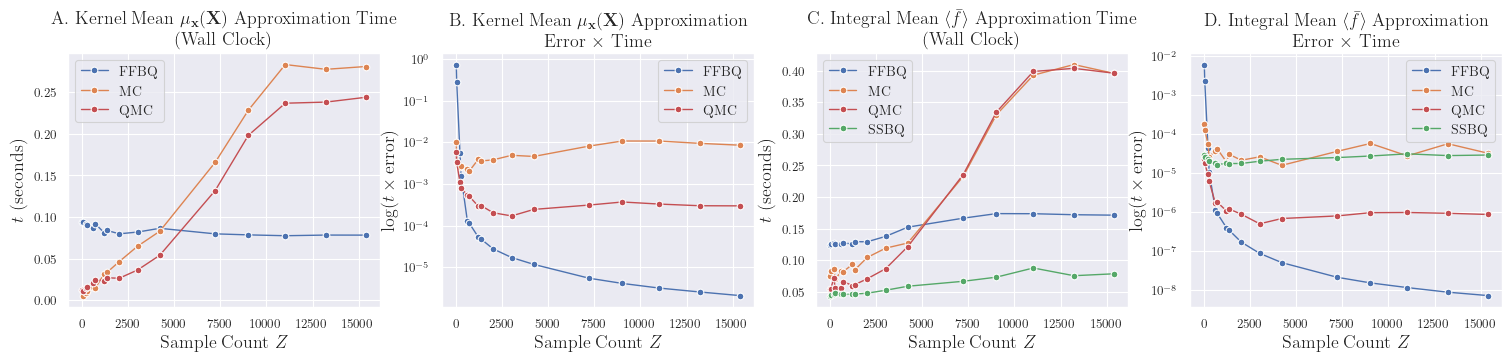

In [108]:
fig, ax = plt.subplots(1, 4, figsize=(18.5, 3.3))

# KMU TIME
sns.lineplot(
    kmu_time_sum, x="Nconv", y="time_mean", hue="operator",
    linewidth=1, marker="o" , ax=ax[0], palette=["#4c72b0", "#dd8452", "#c44e52"]
)
handles0, labels0 = ax[0].get_legend_handles_labels()
ax[0].set(xlabel="Sample Count $Z$", ylabel="$t$ (seconds)")
ax[0].legend(handles=handles0, labels=["FFBQ", "MC", "QMC"], fontsize=10)

# KMU TIME X ERROR
sns.lineplot(
    kmu_time_sum, x="Nconv", y="t_err_mean", hue="operator",
    linewidth=1, marker="o", ax=ax[1], palette=["#4c72b0", "#dd8452", "#c44e52"]
)
ax[1].set(yscale="log", xlabel="Sample Count $Z$", ylabel="$\log(t \\times \mathrm{error})$")
handles1, labels1 = ax[1].get_legend_handles_labels()
ax[1].legend(handles=handles1, labels=["FFBQ", "MC", "QMC"], fontsize=10)

# FULL TIME
sns.lineplot(
    full_time_sum, x="Nconv", y="time_mean", hue="operator",
    linewidth=1, marker="o" , ax=ax[2], palette=["#4c72b0", "#dd8452", "#c44e52", "#55a868"]
)
handles2, labels2 = ax[2].get_legend_handles_labels()
ax[2].set(xlabel=r"Sample Count $Z$", ylabel="$t$ (seconds)")
ax[2].legend(handles=handles2, labels=["FFBQ", "MC", "QMC", "SSBQ"], fontsize=10)

# FULL TIME X ERROR
sns.lineplot(
    full_time_sum, x="Nconv", y="t_err_mean", hue="operator",
    linewidth=1, marker="o", ax=ax[3], palette=["#4c72b0", "#dd8452", "#c44e52", "#55a868"]
)
ax[3].set(yscale="log", xlabel="Sample Count $Z$", ylabel="$\log(t \\times \mathrm{error})$")
handles3, labels3 = ax[3].get_legend_handles_labels()
ax[3].legend(handles=handles3, labels=["FFBQ", "MC", "QMC", "SSBQ"], fontsize=10)


ax[0].set_title('A. Kernel Mean $\mu_{\mathbf{x}}(\mathbf{X})$ Approximation Time \n (Wall Clock)')
ax[1].set_title('B. Kernel Mean $\mu_{\mathbf{x}}(\mathbf{X})$ Approximation \n Error $\\times$ Time')
ax[2].set_title('C. Integral Mean $\langle \\bar{f} \\rangle$ Approximation Time \n (Wall Clock)')
ax[3].set_title('D. Integral Mean $\langle \\bar{f} \\rangle$ Approximation \n Error $\\times$ Time')
plt.show()
fig.savefig("gmm_time.pdf", format="pdf", bbox_inches="tight")

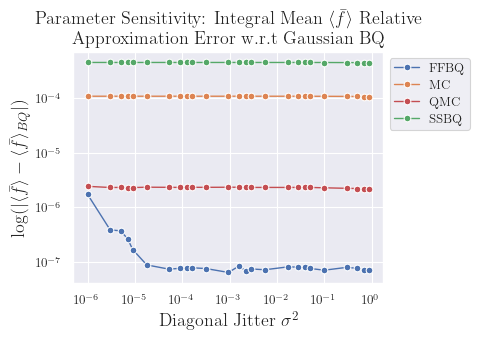

In [114]:
# fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# # absolute error
# g = sns.lineplot(
#     gmm_noise_sum, x="diag", y="bqerr_mean", hue="operator",
#     linewidth=1, marker="o", palette=["#4c72b0", "#dd8452", "#c44e52", "#55a868"], ax=ax[0]
# )
# ax[0].set(yscale="log", xscale="log", xlabel="Diagonal Noise Value", ylabel="Log Error w.r.t Gaussian BQ")
# handles0, labels0 = ax[0].get_legend_handles_labels()
# ax[0].get_legend().remove()
# # ax[0].legend(handles=handles0, labels=["FFBQ", "MC", "QMC", "SSBQ"], fontsize=11, loc="center right")

# # relative error
# sns.lineplot(
#     gmm_noise_sum, x="diag", y="rel_err", hue="operator",
#     linewidth=1, marker="o", palette=["#4c72b0", "#dd8452", "#c44e52", "#55a868"], ax=ax[1]
# )
# ax[1].set(xscale="log", yscale="log", xlabel="Diagonal Noise Value", ylabel="Log(Relative Error) w.r.t minimum error")
# handles1, labels1 = ax[1].get_legend_handles_labels()
# ax[1].legend(handles=handles1, labels=["FFBQ", "MC", "QMC", "SSBQ"], fontsize=11)


fig, ax = plt.subplots(1, 1, figsize=(4, 3))
g = sns.lineplot(
    gmm_noise_sum, x="diag", y="bqerr_mean", hue="operator",
    linewidth=1, marker="o", palette=["#4c72b0", "#dd8452", "#c44e52", "#55a868"], ax=ax
)
ax.set(yscale="log", xscale="log", xlabel="Diagonal Jitter $\sigma^2$", ylabel="$\log(|\langle \\bar{f} \\rangle - \langle \\bar{f} \\rangle_{BQ}|)$")
ax.set_title('Parameter Sensitivity: Integral Mean $\langle \\bar{f} \\rangle$ Relative \n Approximation Error w.r.t Gaussian BQ')
handles0, labels0 = ax.get_legend_handles_labels()
ax.legend(handles=handles0, labels=["FFBQ", "MC", "QMC", "SSBQ"], fontsize=10)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), )
plt.show()
fig.savefig("gmm_diag.pdf", format="pdf", bbox_inches="tight")


In [125]:
sns.set_theme()
sns.set_context("paper", rc={
    # 'font.size': 11,
    # "axes.labelsize": 12,
    'text.usetex': True,
    "font.family" : "serif",
    "font.serif" : ["Computer Modern Roman"],
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

plt.rcParams.update({
    'font.size': 13,
    "axes.titlesize":14,
    "axes.labelsize": 14,
    'text.usetex': True,
    "font.family" : "serif",
    "font.serif" : ["Computer Modern Roman"],
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

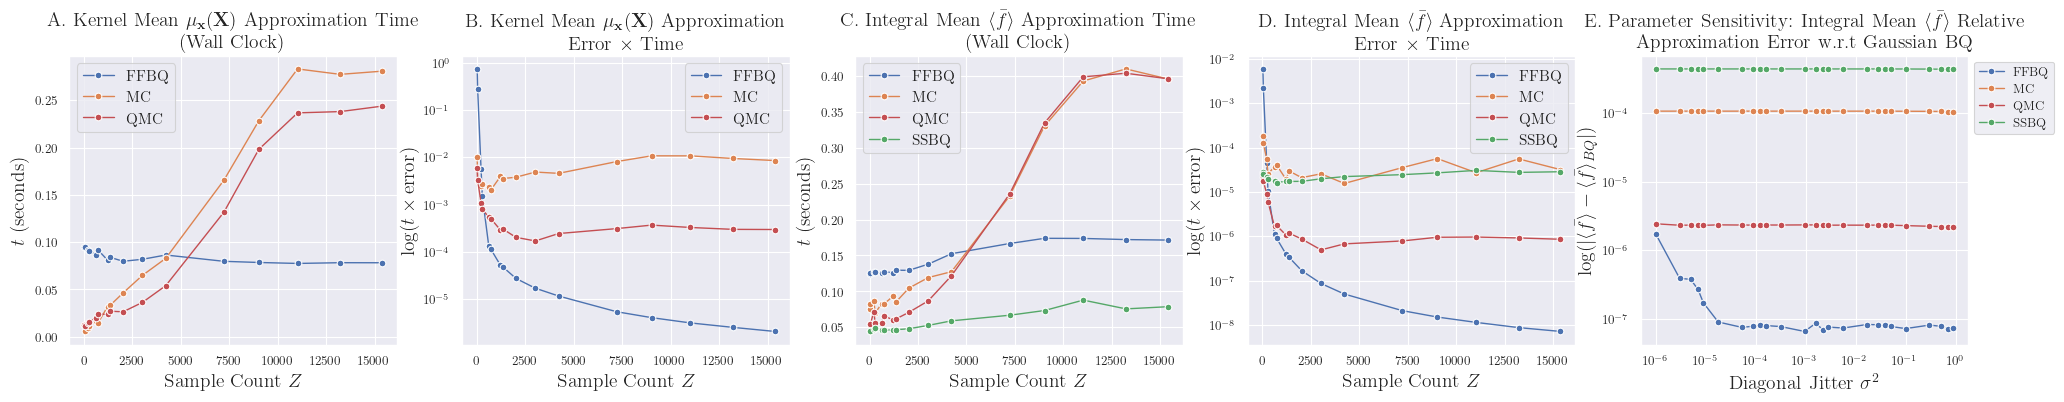

In [127]:
fig, ax = plt.subplots(1, 5, figsize=(24.5, 3.75))


# KMU TIME
sns.lineplot(
    kmu_time_sum, x="Nconv", y="time_mean", hue="operator",
    linewidth=1, marker="o" , ax=ax[0], palette=["#4c72b0", "#dd8452", "#c44e52"]
)
handles0, labels0 = ax[0].get_legend_handles_labels()
ax[0].set(xlabel="Sample Count $Z$", ylabel="$t$ (seconds)")
ax[0].legend(handles=handles0, labels=["FFBQ", "MC", "QMC"], fontsize=11)

# KMU TIME X ERROR
sns.lineplot(
    kmu_time_sum, x="Nconv", y="t_err_mean", hue="operator",
    linewidth=1, marker="o", ax=ax[1], palette=["#4c72b0", "#dd8452", "#c44e52"]
)
ax[1].set(yscale="log", xlabel="Sample Count $Z$", ylabel="$\log(t \\times \mathrm{error})$")
handles1, labels1 = ax[1].get_legend_handles_labels()
ax[1].legend(handles=handles1, labels=["FFBQ", "MC", "QMC"], fontsize=11)

# FULL TIME
sns.lineplot(
    full_time_sum, x="Nconv", y="time_mean", hue="operator",
    linewidth=1, marker="o" , ax=ax[2], palette=["#4c72b0", "#dd8452", "#c44e52", "#55a868"]
)
handles2, labels2 = ax[2].get_legend_handles_labels()
ax[2].set(xlabel=r"Sample Count $Z$", ylabel="$t$ (seconds)")
ax[2].legend(handles=handles2, labels=["FFBQ", "MC", "QMC", "SSBQ"], fontsize=11)

# FULL TIME X ERROR
sns.lineplot(
    full_time_sum, x="Nconv", y="t_err_mean", hue="operator",
    linewidth=1, marker="o", ax=ax[3], palette=["#4c72b0", "#dd8452", "#c44e52", "#55a868"]
)
ax[3].set(yscale="log", xlabel="Sample Count $Z$", ylabel="$\log(t \\times \mathrm{error})$")
handles3, labels3 = ax[3].get_legend_handles_labels()
ax[3].legend(handles=handles3, labels=["FFBQ", "MC", "QMC", "SSBQ"], fontsize=11)

# DIAG NOISE
sns.lineplot(
    gmm_noise_sum, x="diag", y="bqerr_mean", hue="operator",
    linewidth=1, marker="o", palette=["#4c72b0", "#dd8452", "#c44e52", "#55a868"], ax=ax[4]
)
ax[4].set(yscale="log", xscale="log", xlabel="Diagonal Jitter $\sigma^2$", ylabel="$\log(|\langle \\bar{f} \\rangle - \langle \\bar{f} \\rangle_{BQ}|)$")
handles4, labels4 = ax[4].get_legend_handles_labels()
ax[4].legend(handles=handles4, labels=["FFBQ", "MC", "QMC", "SSBQ"], fontsize=11)
sns.move_legend(ax[4], "upper left", bbox_to_anchor=(1, 1), )


ax[0].set_title('A. Kernel Mean $\mu_{\mathbf{x}}(\mathbf{X})$ Approximation Time \n (Wall Clock)')
ax[1].set_title('B. Kernel Mean $\mu_{\mathbf{x}}(\mathbf{X})$ Approximation \n Error $\\times$ Time')
ax[2].set_title('C. Integral Mean $\langle \\bar{f} \\rangle$ Approximation Time \n (Wall Clock)')
ax[3].set_title('D. Integral Mean $\langle \\bar{f} \\rangle$ Approximation \n Error $\\times$ Time')
ax[4].set_title('E. Parameter Sensitivity: Integral Mean $\langle \\bar{f} \\rangle$ Relative \n Approximation Error w.r.t Gaussian BQ')

plt.show()
fig.savefig("gmm_combined.pdf", format="pdf", bbox_inches="tight")